In [1]:
import json
import itertools  # itertools.combinations may be useful
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import streamlit as st
# import altair as alt
import pickle
import plotly.graph_objects as go
import plotly.express as px

# can conda install everything except streamlit. do it with pip in the conda env


In [2]:
chr_lengths = {'1': 250_000_000,
                '2':   245_000_000,
                '3':   200_000_000,
                '4':   195_000_000,
                '5':   185_000_000,
                '6':   175_000_000,
                '7':   160_000_000,
                '8':   146_000_000,
                '9':   142_000_000,
                '10':  136_000_000,
                '11':  136_000_000,
                '12':  135_000_000,
                '13':  116_000_000,
                '14':  108_000_000,
                '15':  103_000_000,
                '16':  91_000_000,
                '17':  82_000_000,
                '18':  80_000_000,
                '19':  60_000_000,
                '20':  64_000_000,
                '21':  48_000_000,
                '22':  51_000_000,
                'X':   156_000_000,
                'Y':   59_000_000}

domain_starts = []
start = 0
domain_starts.append(start)
for cl in chr_lengths.values():
    start += cl
    domain_starts.append(start)

print(domain_starts)

[0, 250000000, 495000000, 695000000, 890000000, 1075000000, 1250000000, 1410000000, 1556000000, 1698000000, 1834000000, 1970000000, 2105000000, 2221000000, 2329000000, 2432000000, 2523000000, 2605000000, 2685000000, 2745000000, 2809000000, 2857000000, 2908000000, 3064000000, 3123000000]


In [3]:
def load_json(input):
    # Opening JSON file
    f = open(input)
    # returns JSON object as
    # a dictionary
    data = json.load(f)
    # Closing file
    f.close() 
    return data

In [4]:
# OBSOLETE
def get_cn(key,input):
    data = load_json(input)
    for i,el in enumerate(data["intervals"]):
        if el['iid']==key:
            return el['y']
        else:
            continue

    return 0

In [5]:
def draw_network(G):
    # Set overall figure size
    fig = plt.figure(figsize=(20,20))
    fig.tight_layout()

    nx.draw_networkx(G)

In [6]:
def draw_network_colors(G,jsonfile):
    input = jsonfile
    node_list = list(G.nodes())
    cn = []
    for node in node_list:
        cn.append(get_cn(node,input))

    #nx.set_node_attributes(G, cn, 'cn')

    fig = plt.figure(figsize=(70,10))
    ax = fig.add_subplot(111)

    #cmap = plt.cm.get_cmap('rainbow')
    cmap = plt.cm.coolwarm
    vmin = 0
    vmax = max(cn) #if len(cn)>0 else 0
    # nx.draw(G, pos=nx.spring_layout(G), node_color = cn, vmin=vmin, vmax=vmax, cmap=cmap,with_labels=True)

    pos=nx.get_node_attributes(G,'pos')
    # dom=nx.get_node_attributes(G,'domain')

    # d_starts = [0, 140_000_000]
    # final_positions = {}

    # for pos, dom in zip(pos.items(), dom.items()):
    #     label, (x, y) = pos
    #     _, d = dom
    #     final_positions[label] = [x + domain_borders[d], y]

    xmax = max([v[0] for k,v in pos.items()])
    
    nx.draw_networkx(G, pos, node_shape="s", node_color = cn, node_size=100, font_size=8,
            vmin=vmin, vmax=vmax, cmap=cmap, with_labels=True,
            ax=ax)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm,fraction=0.046, pad=0.04, aspect=10) # https://matplotlib.org/stable/api/colorbar_api.html

    ax.tick_params(left=True, right=True, top=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_title("The Longest Chain")
    ax.set_ylabel("Copy Number")
    ax.set_xlabel("Starting Position/$10^{9}$")
    #ax.set_xlim(0,xmax*1.01)
    #ax.set_xscale("log")
  

In [7]:
def check_oncone_cov(df):

    # check if a node overlaps with the following oncongenes

    # oncognes = {'oncogene': [chromosome number, start point, end point],...}
    oncogenes = {'EGFR': ['7', 55019017,55211628],
                'c-MYC': ['8', 127735434,127742951],
                'ERBB2': ['17', 39688094,39728658],
                'MDM2/CDK4': ['12', 57747727,57752310]}
    
    for key,value in oncogenes.items():
        print("---",key,"Chr:",value[0])
        print(df[
            ((df['Chromosome']==value[0]) & (df['Start_Point']<value[1]) & (df['End_Point']>value[1])) | 
            ((df['Chromosome']==value[0]) & (df['Start_Point']<value[2]) & (df['End_Point']>value[2])) |
            ((df['Chromosome']==value[0]) & (df['Start_Point']>value[1]) & (df['End_Point']<value[2])) |
            ((df['Chromosome']==value[0]) & (df['Start_Point']<value[1]) & (df['End_Point']>value[2]))
            ][['Source','Copy_Number','Start_Point','End_Point']]   )
        

In [8]:
def position(jsonfile,_df,node):
    x1,x2,y=0,0,0
    if node in set(_df['Source'].to_list()):
        x1=int(_df[_df['Source']==node]['Start_Point'].values[0])
        x2=int(_df[_df['Source']==node]['End_Point'].values[0]) 
        y=int(_df[_df['Source']==node]['Copy_Number'].values[0])
    else:
        # some nodes doesn't have Source entry so we need to go back to the source
        # we can improve this later
        data = load_json(jsonfile)
        for i,el in enumerate(data["intervals"]):            
            if el['iid']==node:
                x1=el['startPoint']
                x2=el['endPoint']
                y=el['y']
            else:
                continue

    
    if node!='loose' and (x1==0 or x2==0):
        print("CAN'T FIND LOCATION DATA FOR",node)

    return x1,y

In [9]:
def find_longest_chain(G,df):
    diameter = max([max(j.values()) for (i,j) in nx.shortest_path_length(G)])
    print("the longest is path length is", diameter)

    # print(df)

    G2=nx.DiGraph()

    how_many_longest = 0

    for (i,j) in nx.shortest_path_length(G):
        # print((i,j),j.values()) # prints as below (the default longest chain)
        # (2798, {2798: 0, 2799: 1, 2800: 2, 2803: 3, 2804: 4, 2806: 5, 2807: 6, 2808: 7}) dict_values([0, 1, 2, 3, 4, 5, 6, 7])
        print((i,j))
        if max(j.values()) == diameter:

            how_many_longest += 1
            node_list = list(j.keys())
            print("node list and its length:", node_list, len(node_list))

            for n,node in enumerate(node_list):
                x1=int(df[df['Source']==node]['Start_Point'].values[0])
                x2=int(df[df['Source']==node]['End_Point'].values[0])
                y=int(df[df['Source']==node]['Copy_Number'].values[0])           
                
                # Add nodes and connect them                
                G2.add_node(node,pos=(x1,y),domain=df[df['Source']==node]['Chromosome'].values[0])
                if node in set(df['Source'].tolist()): 
                    for sink in df[df['Source']==node]['Sink'].to_list():
                        if sink in node_list:
                            G2.add_edge(node,sink)
                # if n>0:
                #     G2.add_edge(node_list[n-1],node_list[n])

    print("how many with this size:",how_many_longest)

    # print("longest chain -->",G2.nodes)

    return G2,diameter

In [10]:
def find_a_chain(G,df):

    ### UNDER CONSTRUCTION 
    ### FIND A SPESIFIC PATH HERE

    diameter = max([max(j.values()) for (i,j) in nx.shortest_path_length(G)])
    print("the longest is path length is", diameter)

    # print(df)

    G2=nx.DiGraph()

    how_many_longest = 0

    for (i,j) in nx.shortest_path_length(G):
        # print((i,j),j.values()) # prints as below (the default longest chain)
        # (2798, {2798: 0, 2799: 1, 2800: 2, 2803: 3, 2804: 4, 2806: 5, 2807: 6, 2808: 7}) dict_values([0, 1, 2, 3, 4, 5, 6, 7])
        print((i,j))
        # if max(j.values()) == diameter:

        how_many_longest += 1
        node_list = list(j.keys())
        print("node list and its length:", node_list, len(node_list))

        for n,node in enumerate(node_list):
            x1=int(df[df['Source']==node]['Start_Point'].values[0])
            x2=int(df[df['Source']==node]['End_Point'].values[0])
            y=int(df[df['Source']==node]['Copy_Number'].values[0])           
            
            # Add nodes and connect them                
            G2.add_node(node,pos=(x1,y),domain=df[df['Source']==node]['Chromosome'].values[0])
            if node in set(df['Source'].tolist()): 
                for sink in df[df['Source']==node]['Sink'].to_list():
                    if sink in node_list:
                        G2.add_edge(node,sink)
            # if n>0:
            #     G2.add_edge(node_list[n-1],node_list[n])

    print("how many with this size:",how_many_longest)

    # print("longest chain -->",G2.nodes)

    return G2,diameter

In [11]:
def find_simple_cycles(jsonfile,G,df):
    G2 = nx.DiGraph()
    cycles = sorted(nx.simple_cycles(G)) # A list of cycles
    print(cycles)
    for cycle in cycles:
        for i,c in enumerate(cycle):
            # c = cycle[i]
            if len(cycle)==1:
                G2.add_node(c,pos=position(jsonfile,df,c))
                G2.add_edge(c,cycle[0])
            else:
                if i==len(cycle)-1: # connect last node to the first
                    G2.add_edge(c,cycle[0])
                else:
                    if i==0:
                        G2.add_node(c,pos=position(jsonfile,df,c))
                        G2.add_node(cycle[i+1],pos=position(jsonfile,df,c))
                        G2.add_edge(c,cycle[i+1]) 
                    else:
                        # no need to add the current node, c, as it is already added in the prev iteration of the loop
                        G2.add_node(cycle[i+1],pos=position(jsonfile,df,c))
                        G2.add_edge(c,cycle[i+1]) 

    return G2

In [12]:
# this is not verified yet. will be tested later
def find_longest_chain_2(G,df):

    longest_path = nx.dag_longest_path(G)

    print(longest_path)

In [13]:
def getnodeinfo(nodeID,jsonfile):
    # NEEDS ABS VAL OF SOURCE
    # Returns copy number, starpoint, endpoint information
    # from the first part of json file
    # P.S.: returning just el['y'] is the same as get_cn()
    # this returns start and end points of nodes on top of that
    
    data = load_json(jsonfile)

    for i,el in enumerate(data["intervals"]):            
        if el['iid']==nodeID:
            # if nodeID==454:
            #     print("getnodeinfo",el['y'],el['startPoint'],el['endPoint'],el['chromosome'])
            # print(el['y'],el['startPoint'],el['endPoint'],el['chromosome'],el['title'],el['type'],el['strand'])
            return el['y'],el['startPoint'],el['endPoint'],el['chromosome'],el['title'],el['type'],el['strand']
        else:
            continue
    
    print("getnodeinfo can't find the info",nodeID)

    return 0

In [14]:
def make_dict_of_nodes(jsonfile):
    data = load_json(jsonfile)
    # Iterating through the json

    _nodegroups = [] # recently changed to list of lists. 
    for i,el in enumerate(data["connections"]): # out [:100] for test, otherwise all

        nodeID = abs(el['source'])
        
        if el['type']!='LOOSE':

            if getnodeinfo(nodeID,jsonfile)!=0:
                cn,sp,ep,chr,title,type,strand = getnodeinfo(nodeID,jsonfile)
                source_sign = 1 if el['source'] > 0 else -1
                sink_sign = 1 if el['sink'] > 0 else -1
                _nodegroups.append([nodeID,abs(el['sink']),cn,sp,ep,chr,title,type,strand,el['cid'],el['title'],el['type'],el['weight'],source_sign,sink_sign]) # dict of lists
            else:
                _nodegroups.append([nodeID,abs(el['sink']),0,0,0,0,0,0,0,0,0,0,0,0,0,0])
        else:

            # LOOSE EDGES
            if nodeID in _nodegroups:
                # If the node w/ a Sink is detected, don't overwrite it with a Loose type
                continue
            else:
                # If the node doesn't have a Sink, use it with Loose
                # If its data entry with "sink" comes up later, it will overwrite "loose" version of it
                if getnodeinfo(nodeID,jsonfile)!=0:
                    cn,sp,ep,chr,title,type,strand = getnodeinfo(nodeID,jsonfile)
                    source_sign = 1 if el['source'] > 0 else -1
                    sink_sign = '' 
                    _nodegroups.append([nodeID,'loose',cn,sp,ep,chr,title,type,strand,el['cid'],el['title'],el['type'],el['weight'],source_sign,sink_sign]) # dict of lists
                else:
                    _nodegroups.append([nodeID,'loose',0,0,0,0,0,0,0,0,0,0,0,0,0,0])
                
    return _nodegroups

In [15]:
def handle_index_column(df):
    df2 = df.rename_axis('Source').reset_index()    
    return df2

In [16]:
def clean_zero_cn_nodes(df):
    return df[df['Copy_Number']!=0]

In [17]:
def make_df(jsonfile):
    print("Creating a DataFrame object")
    #df = make_df(jsonfile) # nodeID(source)| sink | CN(y) | start p | end p
    nodedict = make_dict_of_nodes(jsonfile) # this is a dict of lists
    #  = nodeID(source)| sink | CN(y) | start p | end p
    
    # now turn this into a pandas dataframe
    df = pd.DataFrame(nodedict, columns =['Source','Sink', 'Copy_Number','Start_Point','End_Point','Chromosome', 'Title','Type','Strand','cid','Conn_Title','Conn_Type','Weight','SourceSign','SinkSign'])
    
    # df.columns =['Sink', 'Copy_Number','Start_Point', 'End_Point','Chromosome']
    # df2 = handle_index_column(df)

    print(df)

    print("Cleaning DF object from nodes with 0 copy number")
    df_c = clean_zero_cn_nodes(df)
    
    return df,df_c

In [18]:
def make_graph(jsonfile,df):
    G=nx.DiGraph()
    
    print("Constructing the graph")
    # from DF directly, however it sees nan values as a single node of 'nan'
    # G=nx.from_pandas_edgelist(df, 'Source', 'Sink') 

    # Alternative way
    # G.add_edges_from(zip(df_c['Source'].tolist(),df_c['Sink'].tolist())) # Will clean loose later - this gives longest 121 

    # Alternative way to include position info
    for n,node in enumerate(set(df['Source'].tolist())):
        if int(df[df['Source']==node]['Copy_Number'].values[0])>1: # if CN=0, don't waste your time in this node
            G.add_node(node,pos=position(jsonfile,df,node))
            for index,row in df[df['Source']==node].iterrows(): # a node can have more than one connection
                # looping over rows is not ideal in pandas, but the loops should be very small here
                # row[0]=source, row[1]=sink, row[2]=cn, row[3]=sp, row[4]=ep, row[5]=chromosome
                if row[1] != 'loose' and df[df['Source']==row[1]]['Copy_Number'].values.size>1: # don't make the node='loose'
                    if int(df[df['Source']==row[1]]['Copy_Number'].values[0])!=0: # if CN=0, don't waste your time in this node
                        G.add_node(row[1],pos=position(jsonfile,df,row[1])) 
                        G.add_edge(row[0],row[1])   
        else:
            continue

    # just a check, b/c in the previous version that has nodes with cn=0, loose was a node
    if 'loose' in list(G.nodes):
        print("Loose is counted as a node") 

    return G

In [19]:
# Seperated this from the cell below to speed up debugging
jsonfile = '/Users/munal/Desktop/Graph/gGnome.js/json/single_sarcoma_SMF-12-16.json'
# jsonfile = '235884-WG01.json'

df,df_c = make_df(jsonfile)

Creating a DataFrame object
     Source   Sink  Copy_Number  Start_Point  End_Point Chromosome Title  \
0         1      2            3            1   62473706          1     1   
1         1      3            3            1   62473706          1     1   
2         2      3            2     62473707   62872007          1     2   
3         3      4            3     62872008  101410662          1     3   
4         4      4            4    101410663  101490592          1     4   
..      ...    ...          ...          ...        ...        ...   ...   
957     828  loose            2     57231745   62657418          X   828   
958     840  loose            1     75776203   75900402          X   840   
959     844  loose            2     76059305   77354202          X   844   
960     852  loose            1     88790633   88822002          X   852   
961     870  loose            2    139967128  140061359          X   870   

         Type Strand   cid Conn_Title Conn_Type  Weight  So

In [20]:
check_oncone_cov(df)

--- EGFR Chr: 7
     Source  Copy_Number  Start_Point  End_Point
944     484            4     41214833  159345973
--- c-MYC Chr: 8
     Source  Copy_Number  Start_Point  End_Point
673     572           26    127565456  128034642
--- ERBB2 Chr: 17
     Source  Copy_Number  Start_Point  End_Point
258     217            2     34768405   46405402
856     217            2     34768405   46405402
--- MDM2/CDK4 Chr: 12
    Source  Copy_Number  Start_Point  End_Point
80      64            3     55173629   57937429
81      64            3     55173629   57937429


In [179]:
_path,_diameter = find_a_chain(_graph,df)

the longest is path length is 9
(1, {1: 0})
node list and its length: [1] 1
(2, {2: 0})
node list and its length: [2] 1
(3, {3: 0, 4: 1, 5: 2})
node list and its length: [3, 4, 5] 3
(4, {4: 0, 5: 1})
node list and its length: [4, 5] 2
(5, {5: 0})
node list and its length: [5] 1
(6, {6: 0})
node list and its length: [6] 1
(7, {7: 0, 8: 1})
node list and its length: [7, 8] 2
(8, {8: 0})
node list and its length: [8] 1
(9, {9: 0, 10: 1})
node list and its length: [9, 10] 2
(10, {10: 0})
node list and its length: [10] 1
(11, {11: 0, 12: 1})
node list and its length: [11, 12] 2
(12, {12: 0})
node list and its length: [12] 1
(13, {13: 0})
node list and its length: [13] 1
(14, {14: 0, 15: 1, 16: 2})
node list and its length: [14, 15, 16] 3
(15, {15: 0, 16: 1})
node list and its length: [15, 16] 2
(16, {16: 0})
node list and its length: [16] 1
(17, {17: 0, 18: 1})
node list and its length: [17, 18] 2
(18, {18: 0})
node list and its length: [18] 1
(19, {19: 0})
node list and its length: [19] 1


In [173]:
# Construct the graph from df
_graph = make_graph(jsonfile,df) 

Constructing the graph


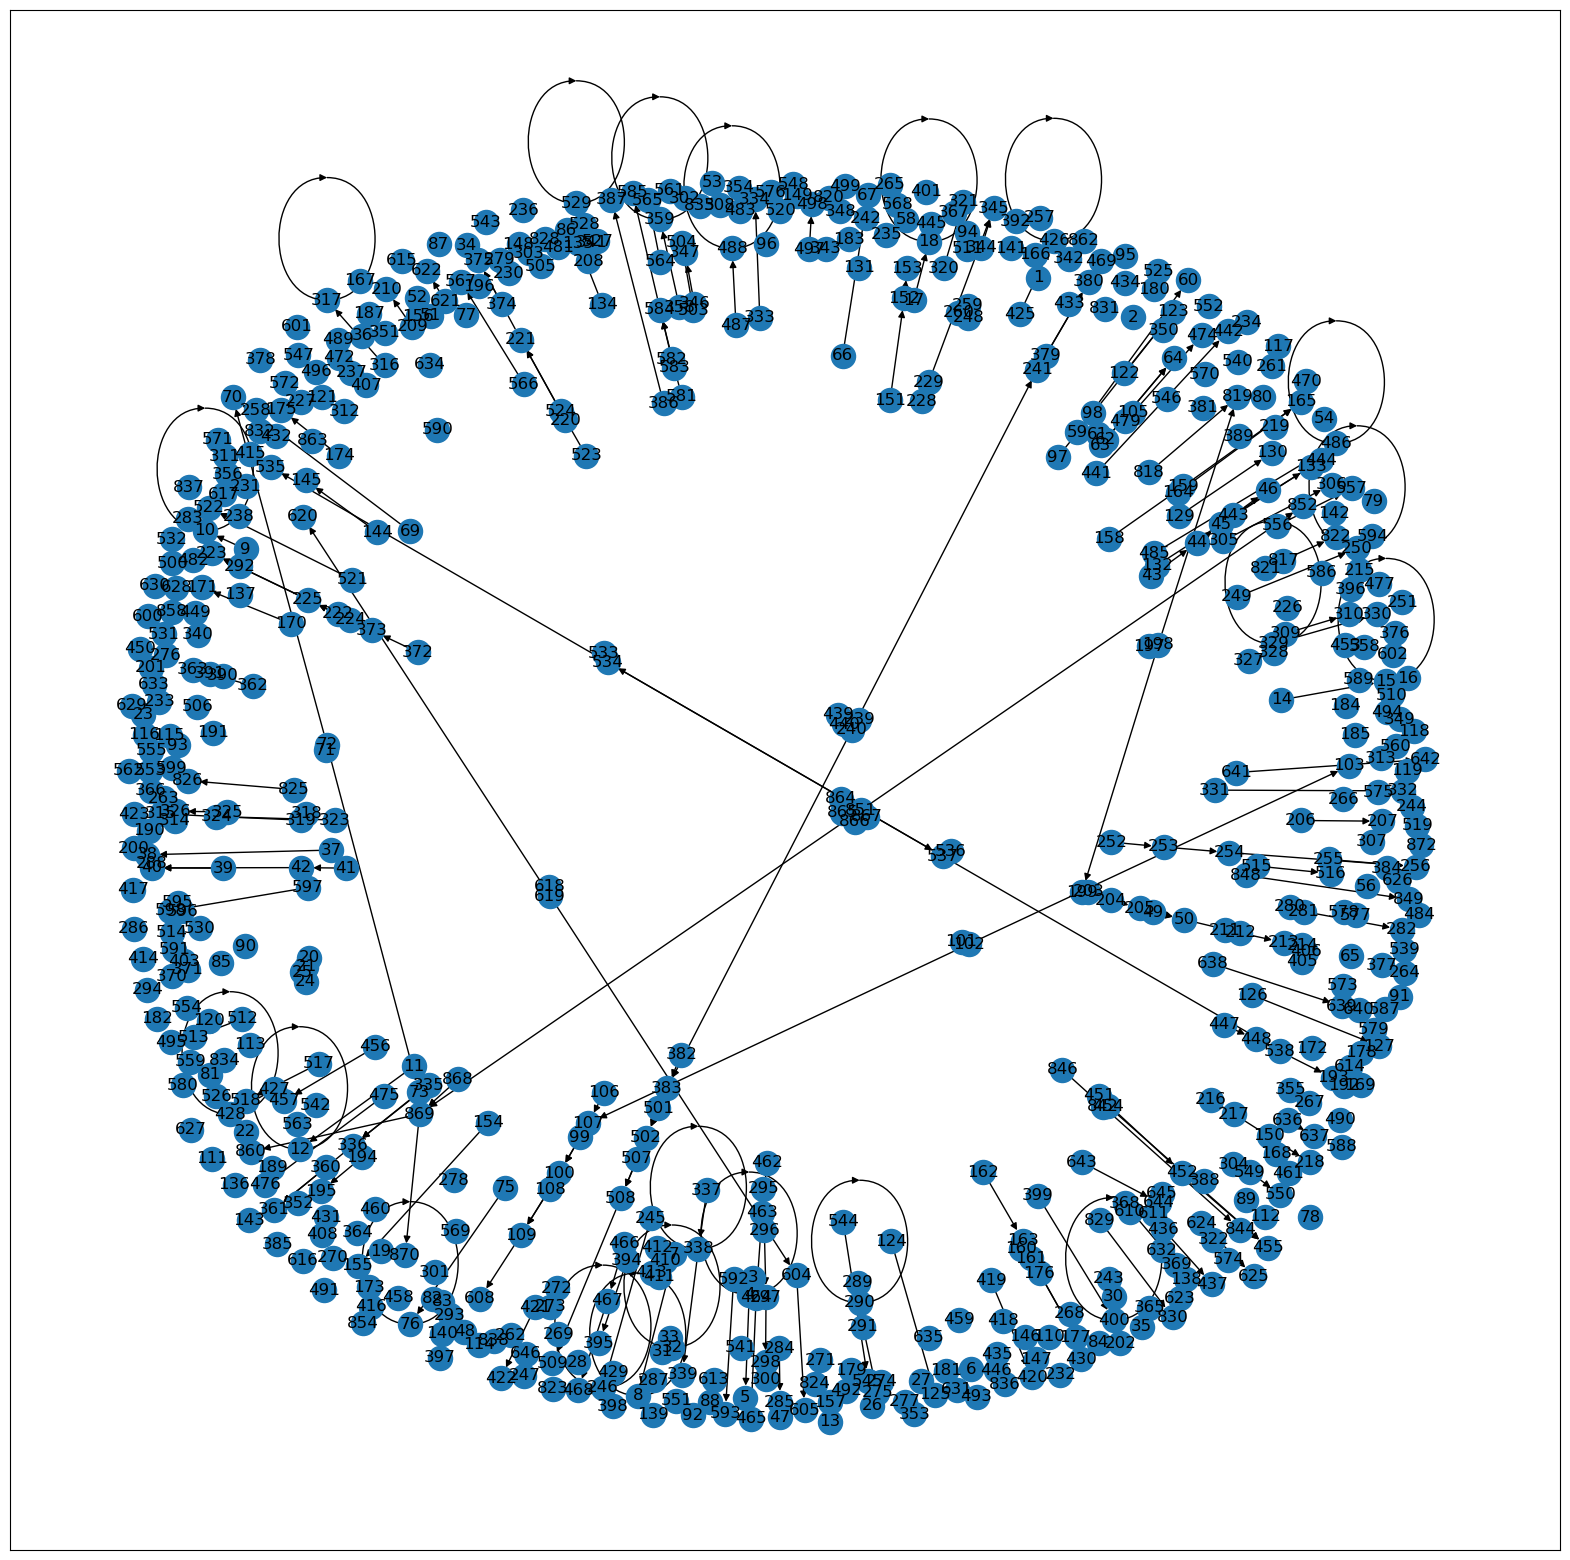

In [174]:
# _graph.remove_node('loose')
draw_network(_graph)

## FIND LONGEST CHAIN

the longest is path length is 9
(1, {1: 0})
(2, {2: 0})
(3, {3: 0, 4: 1, 5: 2})
(4, {4: 0, 5: 1})
(5, {5: 0})
(6, {6: 0})
(7, {7: 0, 8: 1})
(8, {8: 0})
(9, {9: 0, 10: 1})
(10, {10: 0})
(11, {11: 0, 12: 1})
(12, {12: 0})
(13, {13: 0})
(14, {14: 0, 15: 1, 16: 2})
(15, {15: 0, 16: 1})
(16, {16: 0})
(17, {17: 0, 18: 1})
(18, {18: 0})
(19, {19: 0})
(20, {20: 0, 21: 1, 25: 2})
(21, {21: 0, 25: 1})
(25, {25: 0, 21: 1})
(22, {22: 0})
(23, {23: 0})
(24, {24: 0, 25: 1, 21: 2})
(26, {26: 0})
(27, {27: 0})
(28, {28: 0})
(30, {30: 0})
(31, {31: 0, 32: 1, 33: 2})
(32, {32: 0, 33: 1})
(33, {33: 0})
(34, {34: 0})
(35, {35: 0})
(36, {36: 0})
(37, {37: 0, 38: 1})
(38, {38: 0})
(39, {39: 0, 40: 1, 38: 2})
(40, {40: 0, 38: 1})
(41, {41: 0, 42: 1, 40: 2, 38: 3})
(42, {42: 0, 40: 1, 38: 2})
(43, {43: 0, 44: 1, 45: 2, 46: 3})
(44, {44: 0, 45: 1, 46: 2})
(45, {45: 0, 46: 1})
(46, {46: 0})
(47, {47: 0})
(48, {48: 0})
(49, {49: 0, 50: 1, 212: 2, 213: 3, 214: 4, 406: 5})
(50, {50: 0, 212: 1, 213: 2, 214: 3, 406:

/var/folders/1w/smv5xnxd6lb_7klgt1pwwgpw7l6lcq/T/ipykernel_8745/2752374049.py:38: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



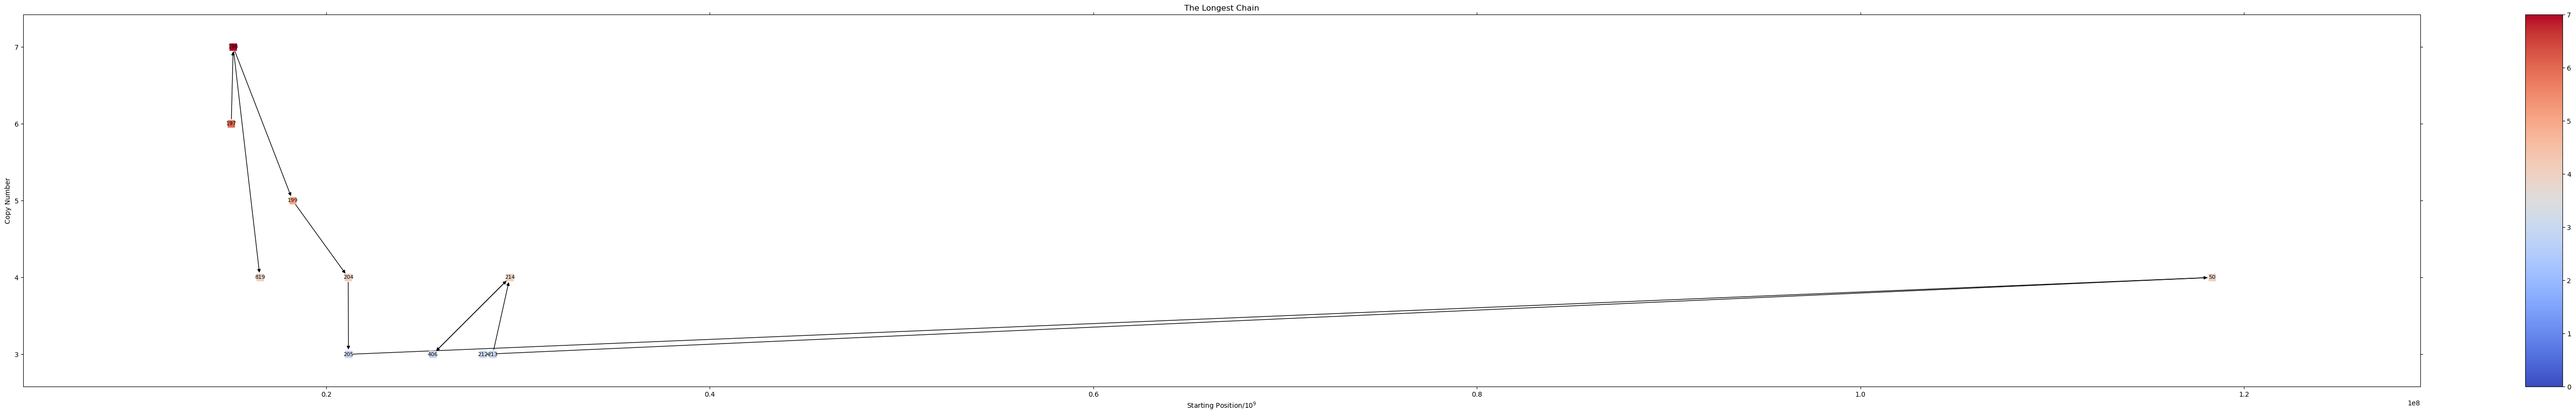

In [175]:
longest_graph,largest_diameter = find_longest_chain(_graph,df)
draw_network_colors(longest_graph,jsonfile)

In [79]:
nx.get_node_attributes(longest_graph, "domain")

{197: '17',
 198: '17',
 199: '17',
 819: 'X',
 204: '17',
 205: '17',
 50: '11',
 212: '17',
 213: '17',
 214: '17',
 406: '22'}

## SIMPLE CYCLES

[[4], [8], [10], [12], [15], [18], [25, 21], [32], [76], [246], [250], [290], [317], [329], [338], [359], [400], [406, 214], [411, 413], [426], [428], [486], [488], [529], [537, 534]]


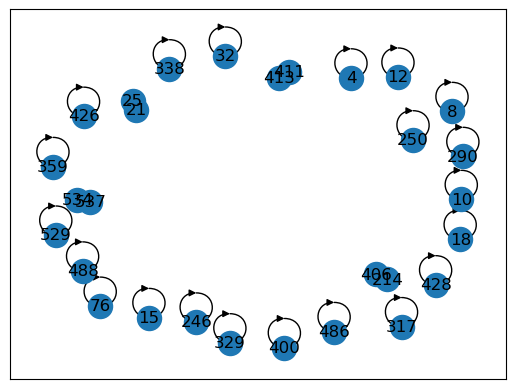

In [33]:
_graph_cycles = find_simple_cycles(jsonfile,_graph,df)
nx.draw_networkx(_graph_cycles)

In [80]:
# dataset = '235884-WG01'
dataset = 'SMF-12-16'
ext = 'v1'
do_sth = 0
flag = 1 # 1=write, 0=load

if do_sth ==1:
    if flag == 1:
        # ## WRITE
        pickle.dump(df, open(f'saved_variables/dataframe_{dataset}_{ext}.txt', 'wb'))
        pickle.dump(_graph, open(f'saved_variables/graph_{dataset}_{ext}.txt', 'wb'))
        pickle.dump(longest_graph, open(f'saved_variables/longest_chain_{dataset}_{ext}.txt', 'wb'))
        pickle.dump(_graph_cycles, open(f'saved_variables/simple_cycles_{dataset}_{ext}.txt', 'wb'))
    else:
        # LOAD
        df = pickle.load(open(f'saved_variables/dataframe_{dataset}_{ext}.txt','rb'))
        _graph = pickle.load(open(f'saved_variables/graph_{dataset}_{ext}.txt','rb'))
        longest_graph = pickle.load(open(f'saved_variables/longest_chain_{dataset}_{ext}.txt','rb'))
        _graph_cycles = pickle.load(open(f'saved_variables/simple_cycles_{dataset}_{ext}.txt','rb'))

In [5]:
print(print(df))

      Source   Sink  Copy_Number  Start_Point  End_Point Chromosome Title  \
0       1545   1585            7     23820865   23821002         13  1545   
1       1508   1509            8     22132854   22133231         13  1508   
2       1506   1565            7     22111602   22111802         13  1506   
3       1376   1377            6     76152669   76153228         12  1376   
4       1373   1540           30     75632352   75632602         12  1373   
...      ...    ...          ...          ...        ...        ...   ...   
7226    3649  loose            2    141108003  152679002          X  3649   
7227    3651  loose            2    152789003  154151402          X  3651   
7228    3653  loose            2    154291603  155701002          X  3653   
7229    3656  loose            8     11289803   11334602          Y  3656   
7230    3658  loose            8     56821603   56881602          Y  3658   

          Type Strand   cid Conn_Title Conn_Type  Weight  SourceSign SinkSi

In [6]:
df[(df['Chromosome']=='X')]

,Source,Sink,Copy_Number,Start_Point,End_Point,Chromosome,Title,Type,Strand,cid,Conn_Title,Conn_Type,Weight,SourceSign,SinkSign
2487,3623,3624,2,3937203,37085002,X,3623,interval,*,2488,REF,REF,1,1,-1
2488,3624,3625,1,37085003,37287802,X,3624,interval,*,2489,REF,REF,1,1,-1
2489,3625,3626,2,37287803,49347602,X,3625,interval,*,2490,REF,REF,1,1,-1
2490,3626,3627,1,49347603,49601602,X,3626,interval,*,2491,REF,REF,1,1,-1
2491,3635,3636,2,63249003,71684802,X,3635,interval,*,2492,REF,REF,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7224,3645,loose,2,120986403,135766202,X,3645,interval,*,7225,,LOOSE,2,1,
7225,3647,loose,2,135886203,141014002,X,3647,interval,*,7226,,LOOSE,2,1,
7226,3649,loose,2,141108003,152679002,X,3649,interval,*,7227,,LOOSE,2,1,
7227,3651,loose,2,152789003,154151402,X,3651,interval,*,7228,,LOOSE,2,1,


In [30]:
df[(df['Source']==160)]

,Source,Sink,Copy_Number,Start_Point,End_Point,Chromosome,Title,Type,Strand,cid,Conn_Title,Conn_Type,Weight,SourceSign,SinkSign
169,160,161,1,93822803,93825602,1,160,interval,*,170,REF,REF,1,1,-1


In [33]:
df[(df['Source']==1530) & (df['Sink']==1531)]

,Source,Sink,Copy_Number,Start_Point,End_Point,Chromosome,Title,Type,Strand,cid,Conn_Title,Conn_Type,Weight,SourceSign,SinkSign
1357,1530,1531,23,22722686,22724402,13,1530,interval,*,1358,REF,REF,23,1,-1


In [34]:
df[(df['Source']==1546) & (df['Sink']==1547)]['SinkSign'].values[0]

-1

In [180]:
GRAPH = _graph

tuples = []
for edge in GRAPH.edges():
    print(edge)
    print(df[(df['Source']==edge[0]) & (df['Sink']==edge[1])]['cid'].values[0])
    tuples.append(edge[0])
    tuples.append(edge[1])

print(sorted(set(tuples)))

(3, 4)
4
(4, 4)
5
(4, 5)
6
(7, 8)
10
(8, 8)
11
(9, 10)
13
(10, 10)
14
(11, 12)
16
(12, 12)
17
(14, 15)
20
(15, 15)
21
(15, 16)
22
(17, 18)
25
(18, 18)
26
(20, 21)
29
(21, 25)
31
(25, 21)
36
(24, 25)
35
(31, 32)
43
(32, 32)
44
(32, 33)
45
(37, 38)
51
(39, 40)
54
(40, 38)
55
(41, 42)
57
(42, 40)
58
(43, 44)
60
(44, 45)
61
(45, 46)
62
(49, 50)
68
(50, 212)
70
(212, 213)
278
(51, 52)
71
(59, 60)
79
(61, 62)
82
(62, 64)
84
(63, 64)
85
(66, 67)
89
(69, 70)
93
(71, 72)
96
(72, 70)
97
(72, 73)
98
(73, 336)
100
(336, 361)
435
(75, 76)
101
(76, 76)
102
(82, 83)
109
(97, 98)
128
(98, 123)
131
(99, 100)
132
(100, 109)
134
(109, 608)
148
(101, 102)
135
(102, 103)
136
(102, 107)
137
(107, 100)
144
(105, 474)
142
(106, 107)
143
(108, 109)
146
(115, 116)
157
(122, 123)
165
(124, 125)
168
(126, 127)
171
(129, 130)
954
(132, 133)
176
(134, 135)
178
(144, 145)
191
(146, 147)
193
(151, 152)
199
(152, 153)
200
(154, 155)
203
(158, 159)
207
(159, 165)
209
(160, 161)
210
(161, 177)
212
(162, 163)
213
(163, 1

In [181]:
%%capture cap --no-stderr

print('{')
print('  "settings": {')
print('    "y_axis": {')
print('      "title": "copy number",')
print('      "visible": true')
print('    },')
print('    "y.axis": "cn",')
print('    "description": "<h3>JaBbA<\/h3> "')
print('  },')

print('  "intervals": [')

for i,iid in enumerate(sorted(set(tuples))):
    Chromosome = df[(df['Source']==iid)]['Chromosome'].values[0]
    Start_Point = df[(df['Source']==iid)]['Start_Point'].values[0]
    End_Point = df[(df['Source']==iid)]['End_Point'].values[0]
    Copy_Number = df[(df['Source']==iid)]['Copy_Number'].values[0]
    Title = df[(df['Source']==iid)]['Title'].values[0]
    Type = df[(df['Source']==iid)]['Type'].values[0]
    Strand = df[(df['Source']==iid)]['Strand'].values[0]
    print('    {')
    print(f'      "chromosome": "{Chromosome}",')
    print(f'      "startPoint": {Start_Point},')
    print(f'      "endPoint": {End_Point},')
    print(f'      "iid": {iid},')
    print(f'      "y": {Copy_Number},')
    print(f'      "annotation": "",')
    print(f'      "title": "{Title}",')
    print(f'      "type": "{Type}",')
    print(f'      "strand": "{Strand}"')
    if i==len(sorted(set(tuples)))-1:
        print('    }')
    else:
        print('    },')

print('  ],')

print('  "connections": [')
for e,edge in enumerate(GRAPH.edges()):
    #print(df[(df['Source']==edge[0]) & (df['Sink']==edge[1])]['cid'].values[0])
    cid = df[(df['Source']==edge[0]) & (df['Sink']==edge[1])]['cid'].values[0]
    source = edge[0]*df[(df['Source']==edge[0]) & (df['Sink']==edge[1])]['SourceSign'].values[0]
    sink = edge[1]*df[(df['Source']==edge[0]) & (df['Sink']==edge[1])]['SinkSign'].values[0]
    Conn_Title = df[(df['Source']==edge[0]) & (df['Sink']==edge[1])]['Conn_Title'].values[0]
    Conn_Type = df[(df['Source']==edge[0]) & (df['Sink']==edge[1])]['Conn_Type'].values[0]
    Weight = df[(df['Source']==edge[0]) & (df['Sink']==edge[1])]['Weight'].values[0]
    print('    {')
    print(f'      "cid": {cid},')
    print(f'      "source": {source},')
    print(f'      "sink": {sink},')
    print(f'      "title": "{Conn_Title}",')
    print(f'      "type": "{Conn_Type}",')
    print(f'      "weight": {Weight},')
    print(f'      "annotation": ""')
    if e==len(GRAPH.edges())-1:
        print('    }')
    else:
        print('    },')


print('  ]')
print('}')

In [182]:
with open('graph_SMF-12-16.json', 'w') as f:
    f.write(cap.stdout)

## PLOTLY TEST

In [34]:
def draw_plotly(G,title):
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = [] # position
    node_y = [] # copy number
    node_id = [] # node id
    node_chr = []
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)
        node_id.append(node)
        if df[df['Source']==node].Chromosome.values[0] == 'X':
            node_chr.append(23)
        elif df[df['Source']==node].Chromosome.values[0] == 'Y':
            node_chr.append(24)
        elif df[df['Source']==node].Chromosome.values[0] == 'M':
            node_chr.append(25)
        else:
            node_chr.append(int(df[df['Source']==node].Chromosome.values[0])) # item() returns numbers as str
    
    unique_values = len(set(df.Chromosome.to_list()))
    unique_values = len(set(node_chr))
    color_bar_values = [val for val in np.linspace(0, 1, unique_values+1) for _ in range(2)]
    discrete_colors = [val for val in px.colors.qualitative.Alphabet for _ in range(2)]
    colorscale = [[value, color] for value, color in zip(color_bar_values, discrete_colors[1:])]
    colorscale.pop(0)
    colorscale.pop(-1)

    ### Compile hover text for each node
    node_text = []
    for n,node in enumerate(G.nodes()):
        next_node='None' if n==len(G.nodes())-1 else ','.join(str(i) for i in df[df['Source']==node]['Sink'].to_list() if i!='loose')
        prev_node='None' if n==0 else ','.join(str(i) for i in df[df['Sink']==node]['Source'].to_list())
        if node_chr[n]==23:
            node_text.append(f'Prev: {prev_node}<br><b>-Node:{node}-</b><br>Next: {next_node}<br>Chromosome: X<br>CN: {node_y[n]}' )
        elif node_chr[n]==24:
            node_text.append(f'Prev: {prev_node}<br><b>-Node:{node}-</b><br>Next: {next_node}<br>Chromosome: Y<br>CN: {node_y[n]}')
        elif node_chr[n]==25:
            node_text.append(f'Prev: {prev_node}<br><b>-Node:{node}-</b><br>Next: {next_node}<br>Chromosome: M<br>CN: {node_y[n]}')
        else:
            node_text.append(f'Prev: {prev_node}<br><b>-Node:{node}-</b><br>Next: {next_node}<br>Chromosome: {node_chr[n]}<br>CN: {node_y[n]}')

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            # colorscale=px.colors.qualitative.Light24,
            colorscale=colorscale,
            reversescale=True,
            color=node_chr,
            size=10,
            symbol=0,
            colorbar=dict(
                thickness=15,
                title='Chromosome Number',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    # Can also be assigned later like below
    # node_trace.text = node_id
    # node_trace.marker.color = node_chr

    fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title=title,
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=15,r=5,t=40),
                    annotations=[ dict(
                        text=f"Number of nodes: {len(node_y)}",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.1, y=1 ) ],
                    xaxis=dict(showgrid=True, zeroline=True, showticklabels=True,showline=True,title_text = "Start Point"),
                    yaxis=dict(showgrid=True, zeroline=True, showticklabels=True,showline=True,title_text = "Copy Number"))
                    )
    fig.show()

In [ ]:
def draw_plotly_domains(G,title):
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = [] # position
    node_y = [] # copy number
    node_id = [] # node id
    node_chr = []
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)
        node_id.append(node)
        if df[df['Source']==node].Chromosome.values[0] == 'X':
            node_chr.append(23)
        elif df[df['Source']==node].Chromosome.values[0] == 'Y':
            node_chr.append(24)
        elif df[df['Source']==node].Chromosome.values[0] == 'M':
            node_chr.append(25)
        else:
            node_chr.append(int(df[df['Source']==node].Chromosome.values[0])) # item() returns numbers as str
    
    unique_values = len(set(df.Chromosome.to_list()))
    unique_values = len(set(node_chr))
    color_bar_values = [val for val in np.linspace(0, 1, unique_values+1) for _ in range(2)]
    discrete_colors = [val for val in px.colors.qualitative.Alphabet for _ in range(2)]
    colorscale = [[value, color] for value, color in zip(color_bar_values, discrete_colors[1:])]
    colorscale.pop(0)
    colorscale.pop(-1)

    ### Compile hover text for each node
    node_text = []
    for n,node in enumerate(G.nodes()):
        next_node='None' if n==len(G.nodes())-1 else ','.join(str(i) for i in df[df['Source']==node]['Sink'].to_list() if i!='loose')
        prev_node='None' if n==0 else ','.join(str(i) for i in df[df['Sink']==node]['Source'].to_list())
        if node_chr[n]==23:
            node_text.append(f'Prev: {prev_node}<br><b>-Node:{node}-</b><br>Next: {next_node}<br>Chromosome: X<br>CN: {node_y[n]}' )
        elif node_chr[n]==24:
            node_text.append(f'Prev: {prev_node}<br><b>-Node:{node}-</b><br>Next: {next_node}<br>Chromosome: Y<br>CN: {node_y[n]}')
        elif node_chr[n]==25:
            node_text.append(f'Prev: {prev_node}<br><b>-Node:{node}-</b><br>Next: {next_node}<br>Chromosome: M<br>CN: {node_y[n]}')
        else:
            node_text.append(f'Prev: {prev_node}<br><b>-Node:{node}-</b><br>Next: {next_node}<br>Chromosome: {node_chr[n]}<br>CN: {node_y[n]}')

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            # colorscale=px.colors.qualitative.Light24,
            colorscale=colorscale,
            reversescale=True,
            color=node_chr,
            size=10,
            symbol=0,
            colorbar=dict(
                thickness=15,
                title='Chromosome Number',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    # Can also be assigned later like below
    # node_trace.text = node_id
    # node_trace.marker.color = node_chr

    fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title=title,
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=15,r=5,t=40),
                    annotations=[ dict(
                        text=f"Number of nodes: {len(node_y)}",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.1, y=1 ) ],
                    xaxis=dict(showgrid=True, zeroline=True, showticklabels=True,showline=True,title_text = "Start Point"),
                    yaxis=dict(showgrid=True, zeroline=True, showticklabels=True,showline=True,title_text = "Copy Number"))
                    )
    fig.show()

In [35]:
draw_plotly(longest_graph,'Network graph of the longest chain')

In [36]:
draw_plotly(_graph,'Network graph of all the paths')

In [37]:
draw_plotly(_graph_cycles,'Network graph of the circular paths')

1534 22 20
--- (1534, (22, 20)) -- (1534, 0)
0
[22, 20]
945 32 10
--- (945, (32, 10)) -- (945, 1)
100
[132, 10]
946 40 9
--- (946, (40, 9)) -- (946, 2)
200
[240, 9]
__PLOT__
XX (-0.8900000000000023, 262.89)
tick_range [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260]


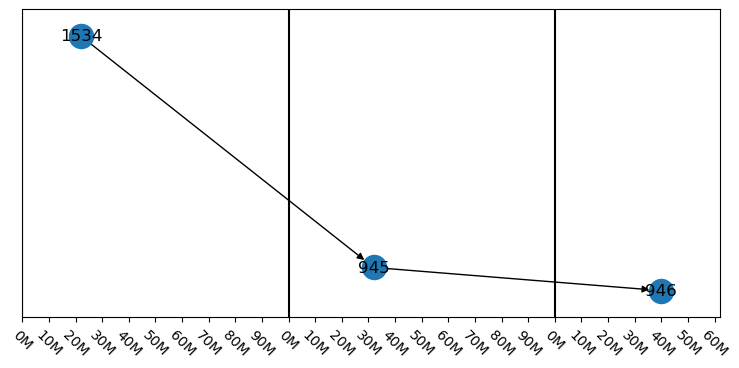

In [71]:
G33 = nx.DiGraph()
G33.add_node(1534, pos=(22, 20), domain=0)
G33.add_node(945, pos=(32, 10), domain=1)
G33.add_node(946, pos=(40, 9), domain=2)
G33.add_edge(1534, 945)
G33.add_edge(945, 946)

d_starts = [0, 100, 200]
# d_starts = {'1': 0, '2': 100, 'X': 200}

positions = nx.get_node_attributes(G33, "pos")
domains = nx.get_node_attributes(G33, "domain")

final_positions = {}

for pos, dom in zip(positions.items(), domains.items()):
    label, (x, y) = pos
    print(label,x,y)
    print("---",pos,"--",dom)
    _, d = dom
    print(d_starts[d])
    final_positions[label] = [x + d_starts[d], y]
    print(final_positions[label])


print("__PLOT__")
fig, ax = plt.subplots(figsize=(9,4))
nx.draw_networkx(G33, final_positions, ax=ax)

# Works properly if d_starts values are modulo of the tick range step (here 10M)
print("XX",ax.get_xlim())
max_xlim = int(ax.get_xlim()[1])
tick_range = range(0, max_xlim, 10)
print("tick_range",list(tick_range))
labels = [f"{(i % d_starts[1])  :.0f}M" for i in tick_range]

ax.set_xlim(0, max_xlim)
ax.set_xticks(tick_range, labels , rotation=-45)
ax.tick_params(bottom=True, labelbottom=True)

for ypos in d_starts:
    ax.axvline(ypos, c="k")